# Urban area mapping using Sentinel 1 data

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

> **_NOTE:_** Please run this notebook using the the Large Environment with 4 cores and 32 GB Memory.

## Background

Urban areas account for a small proportion of global land cover, but support daily human life and exert a great influence on environmental and ecological changes [Xia et al. 2019](https://doi.org/10.3390/rs11121470). 
This means that constant monitoring of the built environment is crucial for sustainable development. 
There are different techniques used to classify urban areas using both optical and radar data. 
The simplest techniques are image thresholding (rule-based classification) and Kmeans clustering (unsupervised machine learning). 

While urban areas can be mapped using optical data, the image quality is strongly affected by weather conditions such as cloud cover. 
This limits the temporal avaliability of clear images in tropical areas that experience very cloudy weather and heavy rains. 
The image quality of radar data is independent of daylight and weather conditions, which makes it more suitable for urban area mapping. 
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

This notebook uses Kmeans Clustering and Otsu image thresholding to classify land as 'urban' then compares those results with the ESA WorldCover global land cover product for the year 2020.

The choice of the number of clusters to use for the Kmeans Clustering and the pixel value most likey to represent the urban land cover can be informed by comparing the prediction images with the "ground truth" dataset.

This notebook contains the following steps:

1. Select a location and time range  for the analysis.
2. Load Sentinel-1 backscatter data for the area of interest. 
3. Convert the digital numbers to dB values for analysis.
4. Generate a median VH and VV polarization composite image from the Sentinel 1 data.
5. Perform Otsu thresholding on the median composite image.
6. Show the Otsu thresholding urbanization prediction images
7. Perform Kmeans Clustering on the median composite image. 
8. Show the Kmeans Clustering urbanization prediction image.
9. Load and show the "ground truth" ESA Worldcover data for the year 2020.
10. Compare the urbanization predictions with the "ground truth" data visually and statistically.


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
# Uncomment the line below to install the tabulate module.
# !pip install tabulate 

In [2]:
# Load the necessary packages.

%matplotlib inline

import warnings
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
from matplotlib.patches import Patch
from tabulate import tabulate
from datacube.utils.geometry import assign_crs
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.filters import try_all_threshold, threshold_otsu
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, plot_lulc

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Urban_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are:
* `central_lat`: The central latitude of the area of interest to analyse.
* `central_lon`: The central longitude of the area of interest to analyse.
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The time range for your analysis, e.g.`('2020')` if you wanted data from all of 2020.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of  Nairobi County, Kenya.

In [4]:
# Define the area of interest.
central_lat = -1.2933
central_lon = 36.8679

lat_buffer = 0.1
lon_buffer = 0.1

# Combine lat, lon with their respective buffers to get area of interest.
lat_range = (central_lat - lat_buffer, central_lat + lat_buffer)
lon_range = (central_lon - lon_buffer, central_lon + lon_buffer)

# Time frame for the analysis.
time_range = "2020"

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# View the study area
display_map(x=lon_range, y=lat_range)

## Load and view the Sentinel-1 data

### Create a datacube query object
We will create a dictionary that will contain the parameters that will be used to load the Sentinel 1 data from the Digital Earth Africa datacube.

In [6]:
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
    "output_crs": "EPSG:6933",
    "resolution": (-10, 10),
}

query

{'y': (-1.3933, -1.1932999999999998),
 'x': (36.7679, 36.9679),
 'time': '2020',
 'output_crs': 'EPSG:6933',
 'resolution': (-10, 10)}

### Load the Sentinel 1 data
The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

In [7]:
ds = load_ard(
    dc=dc, products=["s1_rtc"], measurements=["vv", "vh"], group_by="solar_day", **query
)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 89 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


**Once the load is complete**, examine the data by printing it in the next cell. 
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [8]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 89, y: 2551, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T15:56:20.113636 ... 2020-12...
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.3886 0.3886 0.09932 ... 0.06189 0.03677
    vh           (time, y, x) float32 0.1015 0.1015 0.05205 ... 0.01837 0.01097
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### View the Sentinel 1 data

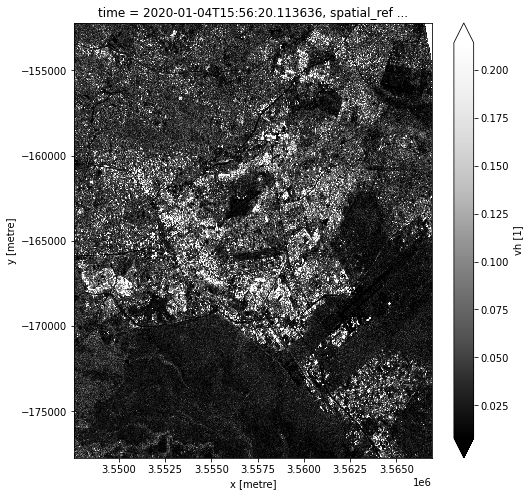

In [9]:
# Plot the first VH observation for the year 2020.
ds.vh.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(8, 8))

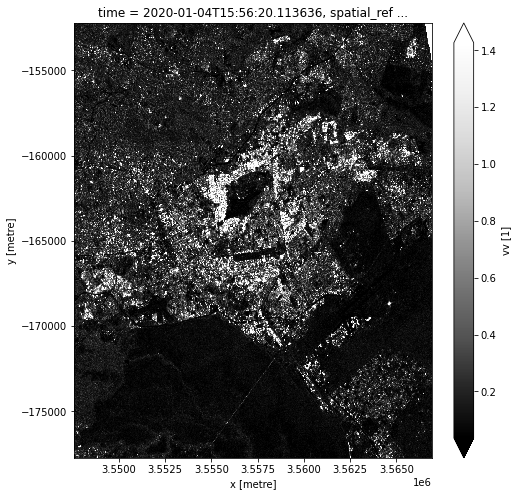

In [10]:
# Plot the first VV observation for the year 2020.
ds.vv.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(8, 8))

## Convert the Digital Numbers (DN) values to Decibel values (dB)

The Sentinel-1 backscatter data is provided as digital number (DN), which can be converted to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}(\text{DN})
\end{equation}


It is often useful to convert the backscatter to decible (dB) for analysis because the backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [11]:
# Convert DN to db values.
ds["vv_db"] = 10 * xr.ufuncs.log10(ds.vv)
ds["vh_db"] = 10 * xr.ufuncs.log10(ds.vh)

## Generate a median value composite image
We will combine all the VH and VV observations in our Sentinel 1 `ds` `xarray.Dataset` into a single, complete (or near complete) image representing the median of the time period.

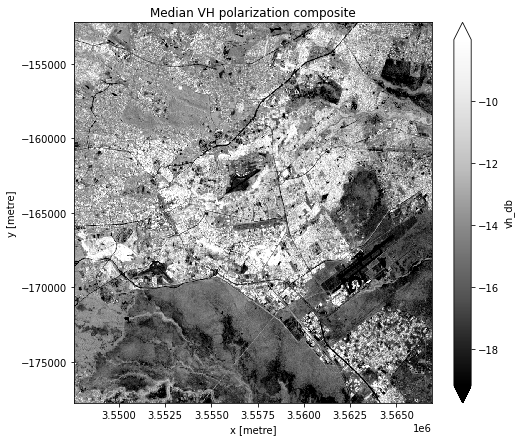

In [12]:
# Obtain the median of all VH observations for the time period.
median_vh = ds.vh_db.median(dim="time")

# Plot the median VH polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vh.plot(cmap="Greys_r", robust=True)
plt.title("Median VH polarization composite");

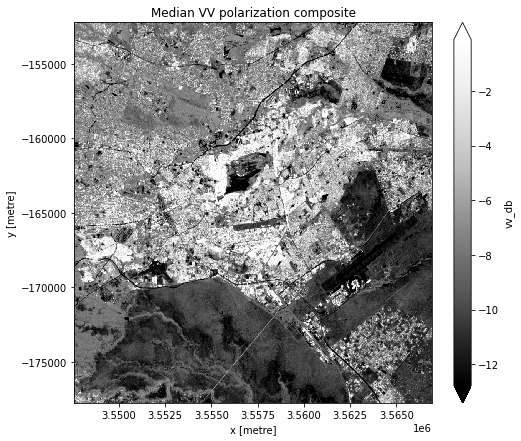

In [13]:
# Obtain the median of all VV observations for the time period.
median_vv = ds.vv_db.median(dim="time")

# Plot the median VV polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vv.plot(cmap="Greys_r", robust=True)
plt.title("Median VV polarization composite");

Merge the median VH and VV polarization composites into one dataset. 

In [14]:
# Merge the median VH and VV polarization composite Data Arrays into one dataset.
img = xr.merge([median_vh.rename("median_vh"), median_vv.rename("median_vv")])

print(img)      

<xarray.Dataset>
Dimensions:      (y: 2551, x: 1931)
Coordinates:
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    median_vh    (y, x) float32 -11.1 -11.1 -12.8 -12.8 ... -17.41 -17.41 -17.79
    median_vv    (y, x) float32 -3.632 -3.632 -5.781 ... -10.98 -10.98 -11.61


We can slice the `ds` dataset, that has 31 time steps to get a time series with 2 time steps for testing.

In [15]:
ds_sel = ds[['vh_db', 'vv_db']].isel(time=[0,1])
print(ds_sel)    

<xarray.Dataset>
Dimensions:      (time: 2, y: 2551, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T15:56:20.113636 2020-01-07T...
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    vh_db        (time, y, x) float32 -9.936 -9.936 -12.84 ... -18.11 -17.59
    vv_db        (time, y, x) float32 -4.105 -4.105 -10.03 ... -11.44 -11.75
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [16]:
ds_sel_vh = ds_sel.vh_db
print(ds_sel_vh)  

<xarray.DataArray 'vh_db' (time: 2, y: 2551, x: 1931)>
array([[[ -9.935921,  -9.935921, -12.836057, ...,        nan,
                nan,        nan],
        [ -9.935921,  -9.935921, -12.836057, ...,        nan,
                nan,        nan],
        [-14.466362, -14.466362, -14.836068, ...,        nan,
                nan,        nan],
        ...,
        [-11.835003, -11.835003, -12.84101 , ..., -15.333416,
         -15.333416, -18.958534],
        [-11.835003, -11.835003, -12.84101 , ..., -15.333416,
         -15.333416, -18.958534],
        [-12.447058, -12.447058, -14.623167, ..., -13.6654  ,
         -13.6654  , -15.198725]],

       [[-14.753721, -14.753721, -12.436754, ..., -14.793446,
         -14.793446, -15.206823],
        [-14.753721, -14.753721, -12.436754, ..., -14.793446,
         -14.793446, -15.206823],
        [-13.819203, -13.819203, -13.412561, ..., -16.069517,
         -16.069517, -16.242376],
        ...,
        [-13.371044, -13.371044, -13.265132, ..., -17

## Timing the functions used in Kmeans Clustering in the Urban Area Mapping notebook and the classifications.py

In [17]:
# Defining functions to use for the Kmeans clustering.

def raster_stack(input_xr):
    """
    Reshape a DataArray or Dataset with spatial structure spatial (and optionally
    temporal) structure into a numpy array with the spatial and optional temporal
    dimensions flattened into one dimension.

    This flattening procedure enables DataArrays and Datasets to be used
    to train and predict with sklearn models.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    input_np : numpy.array
        A numpy array corresponding to input_xr.data (or
        input_xr.to_array().data), with dimensions 'x','y' and 'time'
        flattened into a single dimension, which is the first axis of
        the returned array.
    """
    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        input_xr = input_xr.rename({"longitude": "x", "latitude": "y"})
       
    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype

    # Get the number of bands in the input_xr Dataset.
    bands_list = list(input_xr.data_vars)
    nbands = len(bands_list)
    # Create a dictionary of the bands and their index in the list bands_list.
    bands_dict = {k: v for k, v in enumerate(bands_list)}

    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]
    
    # Get the dimension time of the input_xr Dataset.
    # Create an empty numpy array, model_input, in which each column will hold a
    # flattened band/measurement from the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        model_input = np.empty((height * width * time, nbands), dtype=data_type)
    else:
        model_input = np.empty((height * width, nbands), dtype=data_type)

    # Loop through each band in the input_xr Dataset and add it
    # to the numpy array model_input.
    for i, band in bands_dict.items():
        band_array = np.array(input_xr[band])
        model_input[:, i - 1] = band_array.flatten()

    return model_input


def raster_unstack(output_np, input_xr):
    """
    Reshape a numpy array with no 'missing' elements (NaNs) and
    'flattened' spatiotemporal structure into a DataArray matching the
    spatiotemporal structure of the DataArray

    This enables an sklearn model's prediction to be remapped to the
    correct pixels in the input DataArray or Dataset.

    Last modified: September 2019

    Parameters
    ----------
    output_np : numpy.array
        The first dimension's length should correspond to the number of
        valid (non-NaN) pixels in input_xr.
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    output_xr : xarray.DataArray
        An xarray.DataArray with the same dimensions 'x', 'y' and 'time'
        as input_xr, and the same valid (non-NaN) pixels. These pixels
        are set to match the data in output_np.

    """
    # The  expected output of a sklearn model prediction
    # should just be a 1 dimensional numpy array, output_np, with the
    # size/columns matching the height * width * time  for the
    # dimensions of the input_xr DataArray/Dataset.

    # Cast the input DataArray to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Work around for input_xr Dataset with geographic coordinate reference systems.
    if input_xr.geobox.crs.geographic:
        input_xr = input_xr.rename({"longitude": "x", "latitude": "y"})
        
    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]
        
    # Get the dimension time of the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((time, height, width)) 
        # Convert the output_np numpy array into a xarray Dataset.
        output_np_ds = xr.Dataset(
            data_vars=dict(clustering_predicted=(["time", "y", "x"], output_np)),
            coords=dict(
                time=(["time"], input_xr.coords["time"].values),
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )
    else:
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((height, width))
        # Convert the output_np numpy array into a xarray Dataset.
        output_np_ds = xr.Dataset(
            data_vars=dict(clustering_predicted=(["y", "x"], output_np)),
            coords=dict(
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )
        
    output_np_ds = assign_crs(output_np_ds, input_xr.geobox.crs)
    
    # Work around for input_xr Dataset with geographic coordinate reference systems.
    if input_xr.geobox.crs.geographic:
        output_np_ds = output_np_ds.rename({"x": "longitude", "y": "latitude"})

    return output_np_ds


def show_clustered(predicted_ds):
    """
    Takes the predicted xarray dataset and plots it using the
    clustering_predicted band.

    Last modified: November 2021
    Parameters
    ----------
    predicted_ds : xarray Dataset
    The xarray dataset which is the result of the kmeans clustering.

    Returns
    -------
    An plot of the classification band of the predicted_ds.
    """
    # Display predicted_ds Dataset with upto 6 unique classes.
    image = predicted_ds.clustering_predicted

    # Color list with 6 colors from the virdis color map.
    no_classes = len(np.unique(image))
    colour_list = ["#fde725", "#440154", "#22a884", "#414487", "#2a788e", "#7ad151"]
    colours = colour_list[:no_classes]
    cmap = mcolours.ListedColormap(colours)
    bounds = range(0, no_classes + 1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = [str(i) for i in bounds]
    im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
    cb = im.colorbar
    cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
    cb.set_ticklabels(cblabels)
    plt.axis("off")
    title = f"Kmeans Clustering Predicted Image using {no_classes} clusters"
    plt.title(title)
    plt.show()


def kmeans_clustering(input_xr, cluster_range):
    """
    Perform sklearn Kmeans clustering on the input Dataset
    or Data Array.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    cluster_range : list
        A list of the number of clusters to use to perform the Kmeans clustering
        on the input_xr Dataset.

    Returns
    ----------
    results : dictionary
        A dictionary with the number of clusters as keys and the predicted datasets as
        the values. Each predicted dataset is an xarray.Dataset with the same dimensions
        'x', 'y' and 'time' as the input_xr.

    """
    # Use the raster_stack function to convert the Dataset into a 2 dimensional numpy array.
    model_input = raster_stack(input_xr)

    # Standardize the data.
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Dictionary to save results
    results = {}

    # Perform Kmeans clustering on the input dataset for each number of clusters
    # in the cluster_range list.
    for no_of_clusters in cluster_range:
        # Set up the kmeans classification by specifying the number of clusters
        # with initialization as k-means++.
        km = KMeans(n_clusters=no_of_clusters, init="k-means++")

        # Begin iteratively computing the position of the clusters.
        km.fit(model_input)

        # Use the sklearn kmeans .predict method to assign all the pixels of the
        # model input to a unique cluster.
        flat_predictions = km.predict(model_input)

        # Use the raster_unstack function to convert the flat predictions into a
        # xarray Dataset.
        predicted = raster_unstack(flat_predictions, input_xr)

        # Append the results to a dictionary using the number of clusters as the
        # column as an key.
        results.update({str(no_of_clusters): predicted})

    return results

In [18]:
from deafrica_tools.classification import sklearn_flatten
from deafrica_tools.classification import sklearn_unflatten

### Reshape a Dataset or Data Array into a numpy array

#### Time the sklearn_flatten and raster_stack functions on a dataset or data array with no time dimension.

The `img` dataset has 2 data variables/ bands and no time dimension. The `median_vh` data array has 1 data variable/band and no time dimension.

In [19]:
%timeit sklearn_flatten(img)
%timeit raster_stack(img)

217 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
44 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit sklearn_flatten(median_vh)
%timeit raster_stack(median_vh)

114 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.5 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For a Dataset or Data Array with no time dimension, the raster_stack function is faster than the sklearn_flatten function.

#### Time the sklearn_flatten and raster_stack functions on a dataset or data array a time dimension.

The `ds_sel` dataset has 2 data variables/ bands and a time dimension, 2 time steps. The `ds_sel_vh` data array has 1 data variable/band and a time dimension, 2 time steps.

In [21]:
%timeit sklearn_flatten(ds_sel)
%timeit raster_stack(ds_sel)

670 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
121 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit sklearn_flatten(ds_sel_vh)
%timeit raster_stack(ds_sel_vh)

379 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
62.2 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Reshape a numpy array with no 'missing' elements (NaNs) and 'flattened' spatiotemporal structure into a Dataset matching the spatiotemporal structure of the input DataArray or Dataset

#### Time the `sklearn_unflatten` and `raster_unstack` functions on a dataset or data array with no time dimension.

The `img` dataset has 2 data variables/ bands and no time dimension. The `median_vh` data array has 1 data variable/band and no time dimension.

In [23]:
def prediction_dummy(input_xr):
    """
    Generate a dummy sklearn model prediction numpy array.
    
    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    output_np : numpy.ndarray
        A one dimensional empty numpy.ndarray with the size 'x' *'y'*'time'
        of the input_xr. 
    """
    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype
        
   # Get the dimensions x and y of the input_xr Dataset.
    height = input_xr.dims['y']
    width = input_xr.dims['x']
    
    # Get the time dimension of the input_xr Dataset.
    if 'time' in input_xr.dims:
        time = input_xr.dims['time']
        # Define an empty 1 dimensional numpy array to be a dummy 
        # output of a sklearn model prediction.
        output_np = np.empty((height * width * time ), dtype=data_type)
    else:
        # Define an empty 1 dimensional numpy array to be a dummy 
        # output of a sklearn model prediction.
        output_np = np.empty((height * width), dtype=data_type)
    
    return output_np

In [24]:
input_xr = img
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

995 ms ± 8.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.83 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
input_xr = median_vh
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

978 ms ± 6.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.89 ms ± 9.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For a Dataset or Data Array with no time dimension, the raster_unstack function is faster than the sklearn_unflatten function.

#### Time the sklearn_flatten and raster_stack functions on a dataset or data array with a time dimension.

The `ds_sel` dataset has 2 data variables/ bands and a time dimension, 2 time steps. The `ds_sel_vh` data array has 1 data variable/band and a time dimension, 2 time steps.

In [26]:
# Impute the missing values in the bands of the ds_sel xarray Dataset.
for band in ds_sel.data_vars:
    ds_sel[band].values = np.nan_to_num(ds_sel[band].values, copy=True, nan=np.nanmedian(ds_sel[band]), posinf=np.nanmedian(ds_sel[band]), neginf=np.nanmedian(ds_sel[band]))

input_xr = ds_sel
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

25.8 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.21 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
# Impute the missing values in the bands of the ds_sel_vh xarray Data Array.
ds_sel_vh.values = np.nan_to_num(ds_sel_vh.values, copy=True, nan=np.nanmedian(ds_sel_vh), posinf=np.nanmedian(ds_sel_vh), neginf=np.nanmedian(ds_sel_vh))

input_xr = ds_sel_vh
output_np = prediction_dummy(input_xr)
%timeit sklearn_unflatten(output_np, input_xr)
%timeit raster_unstack(output_np, input_xr)

25.3 s ± 96.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.46 ms ± 89.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For a Dataset or Data Array with a time dimension, the raster_unstack function is faster than the sklearn_unflatten function.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [28]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [29]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-11-25'